# Projet 6 : Catégorisez automatiquement des questions
# <u>A. Exploration des données</u> <br/>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from bs4 import BeautifulSoup
import unicodedata
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from contractions import CONTRACTION_MAP
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import model_selection, metrics
from sklearn.decomposition import LatentDirichletAllocation



%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

#pd.set_option('display.max_colwidth', -1)
#pd.reset_option('display.max_colwidth')

# 1. Les données

Les données ont été obtenues par des requêtes SQL via l'outil **stackexchange explorer**<br/>
Nous avons uniquement récupéré les posts ayant un score supérieur à 5 pour avoir des questions jugées pertinentes.<br/>
En raison des limitations sur les temps d'execution, nous avons fait plusieurs requêtes pour récupérer suffisamment de données pour notre analyse.<br/>





```SQL
SELECT TITLE, BODY, SCORE, TAGS 
FROM POSTS 
WHERE POSTTYPEID=1
AND ID >= XX AND ID < YY
AND SCORE > 5
```

In [2]:
path =r'.' # current dir
datasets_path = glob.glob(path + "/QueryResult*.csv")
total_size = 0
print('# Taille des fichiers')
for f in datasets_path:
    total_size += round(os.path.getsize(f) / 1000000, 2)
    print(f.ljust(30) + str(round(os.path.getsize(f) / 1000000, 2)) + 'MB')
print('# Taille total : ' +  str(round(total_size / 1000, 2)) + 'GB')

# Taille des fichiers
./QueryResults_4.csv          26.03MB
./QueryResults_5.csv          28.23MB
./QueryResults_1.csv          22.19MB
./QueryResults_2.csv          24.86MB
./QueryResults_3.csv          21.25MB
# Taille total : 0.12GB


Nos données sont réparties dans 5 fichiers représentant une taille totale de 0,12Go.

In [3]:
df = pd.DataFrame()
list_ = []
for file_ in datasets_path:
    df_ = pd.read_csv(file_,index_col=None, header=0,low_memory=False, error_bad_lines=False)
    list_.append(df_)
df = pd.concat(list_, ignore_index=True)

## 1.1 Dimensions

In [4]:
df.shape

(64432, 4)

Les données sont composées de : 64 432 posts

## 1.2 Contenu

In [5]:
df.head()

,TITLE,BODY,SCORE,TAGS
0,Java generics variable <T> value,<p>At the moment I am using the following code...,6,<java><generics>
1,How a value typed variable is copied when it i...,<blockquote>\n <p>Swift's string type is a va...,6,<swift><function><value-type>
2,Error while waiting for device: The emulator p...,<p>I am a freshman for the development of the ...,6,<android><android-studio><android-emulator><avd>
3,gulp-inject not working with gulp-watch,<p>I am using gulp-inject to auto add SASS imp...,10,<javascript><node.js><npm><gulp><gulp-watch>
4,React - Call function on props change,<p>My TranslationDetail component is passed an...,12,<reactjs><react-router>


In [6]:
df.dtypes

TITLE    object
BODY     object
SCORE     int64
TAGS     object
dtype: object


| Variable	    | Type  	                         | Description	                                          | 
|---------------|------------------------------------|--------------------------------------------------------|
| TITLE         | Textuelle                     	 | Titre du post (de la question)                         |
| BODY          | Textuelle                          | Contenu textuel du post (détail de la question         |
| SCORE         | Continue - nombre entier            | Score données par les internautes pour la pertinence de la question                 	              |
| TAGS          | Textuelle          | Les tags associés au post. Liste de tags (chaque tag est entre '<' '>'   |

## 1.3 Données manquantes

Vérifions tout d'abord si nos données sont complètes.

In [7]:
#percent of missing values for each column
pd.DataFrame(df.isnull().sum()/df.shape[0]*100,columns=['% Missing Values']).round(2)

,% Missing Values
TITLE,0.0
BODY,0.0
SCORE,0.0
TAGS,0.0


=> La base de données ne contient pas de donnée vide.

# 2. Cleaning and Preprocessing

- Affichons le contenu d'un titre.

In [8]:
display(df.TITLE[3])
display(df.TITLE[12])

'gulp-inject not working with gulp-watch'

'Eclipse git pushes all branches instead of the current one only'

- Le body

In [9]:
display(df.BODY[3])
display(df.BODY[12])

'<p>I am using gulp-inject to auto add SASS imports as they are newly created in my project. This works fine, the new SASS files are imported correctly, however when an already imported file is deleted whilst gulp-watch is running it crashes with the following error:</p>\n\n<pre><code> Error: _dev\\style\\style.scss\nError: File to import not found or unreadable: components/_test - Copy.scss\n       Parent style sheet: stdin\n        on line 2 of stdin\n&gt;&gt; @import "components/_test - Copy.scss";\n</code></pre>\n\n<p>I have spent a good few hours trying to work out why it tries to compile an older version of the stylesheet with out of date imports. I set a delay on the SASS task and the imports are correct in the actual file by the time the gulp-sass runs. I have read that gulp-watch may be caching the stylehseet, but really not sure.</p>\n\n<p>Below are the relevant bits of my Gulp file, at the bottom is a link to my full gulp file.</p>\n\n<p><strong>Here are my watch tasks:</str

'<p>I see this for egit\'s Push to Upstream:</p>\n\n<p><a href="https://i.stack.imgur.com/R9ZuV.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/R9ZuV.png" alt="demo"></a></p>\n\n<p>It says "Push <strong>current</strong> branch."</p>\n\n<p>When I use it, all branches get pushed instead of only the current one. Is there a way to configure it to push only the current branch?</p>\n'

=> Le body contient des caractères HTML,<br.>
=> il peut contenir du code et des caractères de langues étrangères.<br/>
=> Il contient aussi des liens hypertextes

- Les tags

In [10]:
display(df.TAGS[3])
display(df.TAGS[12])

'<javascript><node.js><npm><gulp><gulp-watch>'

'<eclipse><git><egit>'

# 2.1 Traitement de la colonne TITLE

In [11]:
stopword_list = set(stopwords.words('english'))
tokenizer = ToktokTokenizer()

In [12]:
'''
Méthode qui permet de mettre les contractions dans une forme classique.
Méthode récupéré depuis github : (c) @dipanjanS
'''
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def getCleanedText(text) :
    # remove html tags
    text = BeautifulSoup(text, "lxml").get_text()
    
    # remove accented char
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = expand_contractions(text)
    
    # remove non alpha char
    text = re.sub('[\W\d_]', ' ', text)

    # convert to lower case
    text = text.lower()
  
    #remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', ' ',text)
    
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    
    # Remove any single letter except 'c' (correspond au langage)
    text = ' '.join( [w for w in text.split() if len(w)>1 or w == 'c'] )
    
    # remove stopwords
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    meaningful_words = [token for token in tokens if token not in stopword_list]
    
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in meaningful_words]
    
    # join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( stemmed )) 

In [13]:
df['TITLE_P'] = df['TITLE'].apply(lambda x: getCleanedText(x))

In [14]:
df.head()

,TITLE,BODY,SCORE,TAGS,TITLE_P
0,Java generics variable <T> value,<p>At the moment I am using the following code...,6,<java><generics>,java gener variabl valu
1,How a value typed variable is copied when it i...,<blockquote>\n <p>Swift's string type is a va...,6,<swift><function><value-type>,valu type variabl copi pass function hold copi
2,Error while waiting for device: The emulator p...,<p>I am a freshman for the development of the ...,6,<android><android-studio><android-emulator><avd>,error wait devic emul process avd kill
3,gulp-inject not working with gulp-watch,<p>I am using gulp-inject to auto add SASS imp...,10,<javascript><node.js><npm><gulp><gulp-watch>,gulp inject work gulp watch
4,React - Call function on props change,<p>My TranslationDetail component is passed an...,12,<reactjs><react-router>,react call function prop chang


## 2.2 Traitement de la colonne BODY

In [15]:
def getCleanedBody(body) :
    text = getCleanedBodyText(body)
    code = getCleanedBodyCode(body)
    return (text + ' ' + code).strip()

In [16]:
'''
Retrieve body text inside <p>,<h1>,<h2>,<li> tags and return the cleaned and normalized text
'''
def getCleanedBodyText(body) :
    ctext=""
    tags_list=['h1','h2','p','li']
    soup = BeautifulSoup(body, 'html.parser')
    for t in tags_list :
        blocks = soup.findAll(t)
        for block in blocks:
            ctext += " " + block.text    
    return getCleanedText(re.sub(' +',' ',ctext.strip()))

In [17]:
'''
Retrieve the code text inside the body
'''
def getCleanedBodyCode(body) :
    ctext=""
    soup = BeautifulSoup(body, 'lxml')
    code_blocks = soup.findAll('code')
    ctext=" ".join(list(map(lambda x : x.text, code_blocks )))
    table = str.maketrans('', '', string.punctuation)
    words = re.findall(r"[^\W\d_']+", ctext.lower())
    stripped = [w.translate(table) for w in words]
    return( " ".join( stripped ))

In [18]:
df['BODY_P']=df['BODY'].apply(lambda x: getCleanedBody(x))

## 2.3 Traitement de la colonne TAGS

In [19]:
'''
Retourne uniquement les tags et séparé par des espaces
'''
def getTagNames(text) :
    tags = ' '.join(re.findall('<(.*?)>',text))
    return tags.split(' ')

In [20]:
df['TAGS_P']=df['TAGS'].apply(lambda x: getTagNames(x))

In [21]:
df.head()

,TITLE,BODY,SCORE,TAGS,TITLE_P,BODY_P,TAGS_P
0,Java generics variable <T> value,<p>At the moment I am using the following code...,6,<java><generics>,java gener variabl valu,moment use follow code filter jpa reduc block ...,"[java, generics]"
1,How a value typed variable is copied when it i...,<blockquote>\n <p>Swift's string type is a va...,6,<swift><function><value-type>,valu type variabl copi pass function hold copi,swift string type valu type creat new string v...,"[swift, function, value-type]"
2,Error while waiting for device: The emulator p...,<p>I am a freshman for the development of the ...,6,<android><android-studio><android-emulator><avd>,error wait devic emul process avd kill,freshman develop andriod suffer odd question r...,"[android, android-studio, android-emulator, avd]"
3,gulp-inject not working with gulp-watch,<p>I am using gulp-inject to auto add SASS imp...,10,<javascript><node.js><npm><gulp><gulp-watch>,gulp inject work gulp watch,use gulp inject auto add sass import newli cre...,"[javascript, node.js, npm, gulp, gulp-watch]"
4,React - Call function on props change,<p>My TranslationDetail component is passed an...,12,<reactjs><react-router>,react call function prop chang,translationdetail compon pass id upon open bas...,"[reactjs, react-router]"


# 3. Analyse des données

## 3.1 Les titres

In [22]:
df['TITLE_NW'] = df['TITLE_P'].apply(lambda x: len(x.split()))

Voyons le nombre de mots contenus dans les titres.

count    64432.000000
mean         6.070819
std          2.176159
min          0.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         20.000000
Name: TITLE_NW, dtype: float64


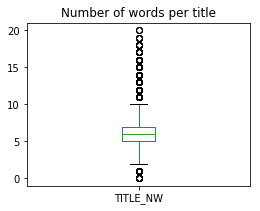

In [23]:
print(df['TITLE_NW'].describe())
df['TITLE_NW'].plot(kind='box', figsize=[4,3])
plt.title('Number of words per title')

## 3.2 Le body

In [24]:
df['BODY_NW'] = df['BODY_P'].apply(lambda x: len(x.split()))
#df['BODY_CODE_NW'] = df['BODY_CODE_P'].apply(lambda x: len(x.split()))

count    64432.000000
mean       156.471008
std        223.928773
min          0.000000
25%         51.000000
50%         94.000000
75%        176.000000
max       5865.000000
Name: BODY_NW, dtype: float64


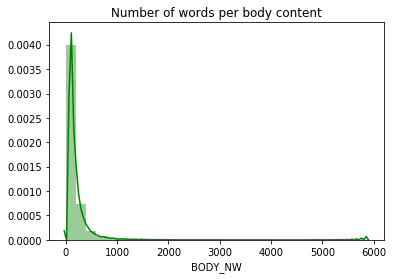

In [25]:
print(df['BODY_NW'].describe())
sns.distplot( df['BODY_NW'], color='g', bins=30 )
plt.title('Number of words per body content')

## 3.3 Les scores

count   64432.000
mean       11.869
std        17.857
min         6.000
25%         7.000
50%         8.000
75%        12.000
max      2183.000
Name: SCORE, dtype: float64


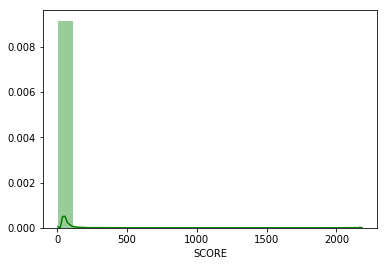

In [26]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df['SCORE'].describe())
plt.figure(figsize=(6, 4))
sns.distplot( df["SCORE"], color='g', bins=20 )

## 3.4 Les tags

#### Distribution des tags

Nombre de tags par post

count   64432.000
mean        3.275
std         1.229
min         1.000
25%         2.000
50%         3.000
75%         4.000
max         5.000
Name: TAGS_NUM, dtype: float64

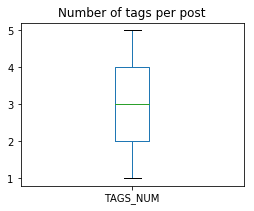

In [28]:
df['TAGS_NUM'] = df['TAGS_P'].apply(lambda x : len(x))
df['TAGS_NUM'].plot(kind='box', figsize=[4,3])
plt.title('Number of tags per post')
df['TAGS_NUM'].describe()

#### Occurences des tags

In [30]:
from collections import Counter
counts = Counter()
for list_tags in df['TAGS_P']:
    counts.update(list_tags)
tags_df = pd.DataFrame.from_dict(counts, orient='index')
tags_df.reset_index(drop = False, inplace = True)
tags_df= tags_df.rename(columns={'index':'tag', 0:'count'})
tags_df=tags_df.sort_values('count', ascending=False)
tags_df.head(10)

,tag,count
9,javascript,6590
5,android,6246
22,python,5441
0,java,5076
60,c++,4646
55,ios,3803
76,c#,3766
20,angular,3642
2,swift,2525
165,php,1764


In [31]:
print("Total number of tags", tags_df.shape[0])

Total number of tags 14523


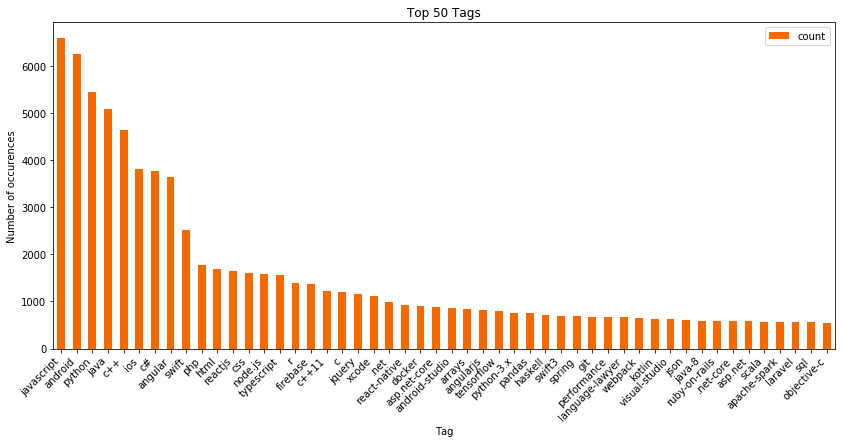

In [34]:
ax = tags_df.head(50).plot(kind = 'bar', figsize = (14,6), color="#f56900")
ax.set_xticklabels(tags_df['tag'])
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.title('Top 50 Tags', fontsize = 'large')
plt.xlabel('Tag')
plt.ylabel('Number of occurences')
plt.show()

In [35]:
tags_df.head(5)

,tag,count
9,javascript,6590
5,android,6246
22,python,5441
0,java,5076
60,c++,4646


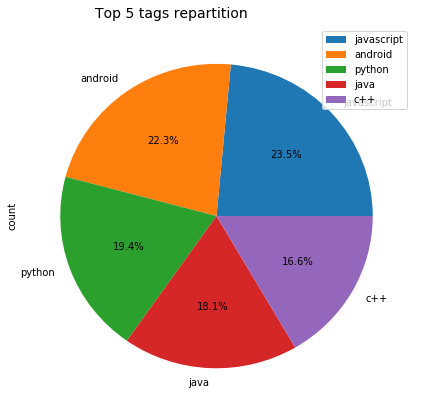

In [36]:
tags_df.head(5).plot(kind='pie',  y = 'count',  labels=tags_df['tag'] ,autopct='%1.1f%%', subplots=True, shadow=False,figsize=(7, 7))
plt.text(0.2, 1.3, "Top 5 tags repartition", ha='right', fontsize = 14);

#### Présence des tags dans le corps du text du post

In [38]:
tags_found=0
for i,row in df.iterrows() :
    tags = row['TAGS_P']
    found = False
    for t in tags :
        if t in row['TITLE_P'] or t in row['BODY_P']:
            found = True
            break
    if found :
        tags_found+=1
print("{:.2f} % of tags retrieved in title or body".format(tags_found/len(df)*100))

73.32 % of tags retrieved in title or body


Dans près de 73% des posts, on retrouve exactement dans le titre ou le body, le ou les tags correspondants. Pour certains tags spécifiques (exemple reactjs, on va retrouver quand même la racine react dans le texte).

## 3.5 Correlations

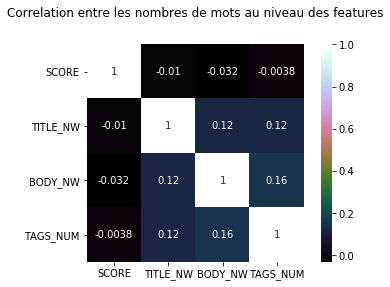

In [39]:
correlation = df.corr()
ax = plt.axes()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix', ax=ax)
ax.set_title('Correlation entre les nombres de mots au niveau des features', y=1.1)

# 4. Sauvegarde des données nettoyées

Pour éviter de refaire les traitements de nettoyage à chaque fois, on sauvegarde le fichier avec les données traitées.

In [40]:
df[['TITLE','BODY','SCORE','TAGS','TITLE_P','BODY_P','TAGS_P']].to_csv('cleaned_data.csv',index = False)